## JuMP: a modeling language for Mathematical Optimization

Mathieu Besançon  
`@matbesancon`  
Polytechnique Montréal & INRIA Lille

## JuMP is...

* Embdedded Domain-Specific Language: (E)-DSL
* Sitting on top of [MathProgBase.jl](https://github.com/JuliaOpt/MathProgBase.jl) (soon MathOptInterface)
* Leveraging solvers doing the "heavy work"


## JuMP as a front-end

- Syntax abstraction on top of MathProgBase.jl
- Solver-independent (as much as possible)
- Relying a lot on Julia macros for consice syntax

Alternatives:
- [Convex.jl](https://github.com/JuliaOpt/Convex.jl) $\Rightarrow$ Disciplined Convex Optimization
- [Parametron.jl](https://github.com/tkoolen/Parametron.jl) $\Rightarrow$ Parametrized optimization

In [1]:
using JuMP
using Clp: ClpSolver # linear problems
using Cbc: CbcSolver # integer linear problems
import Random

## Warm-up: a (0-1) knapsack

In [2]:
# problem data
Random.seed!(42)
const n = 20; const weights = rand(n);
const max_weight = 0.25 * n; const item_values = rand(n);

In [3]:
const knapsack_model = Model(solver = CbcSolver())
const x = @variable(knapsack_model, x[1:n], Bin)
const capacity_constraint = @constraint(
    knapsack_model,
    weights' * x <= max_weight
)

0.5331830160438613 x[1] + 0.4540291355871424 x[2] + 0.017686826714964354 x[3] + 0.17293302893695128 x[4] + 0.9589258763297348 x[5] + 0.9735659798036858 x[6] + 0.30386961108678245 x[7] + 0.17690859963285543 x[8] + 0.9569158240892588 x[9] + 0.5842841475628804 x[10] + 0.9374663045825038 x[11] + 0.1600060971420918 x[12] + 0.4229562655081418 x[13] + 0.602297580266383 x[14] + 0.3634584219520556 x[15] + 0.3834911947029529 x[16] + 0.5929115732384709 x[17] + 0.745181319290827 x[18] + 0.26280883523014786 x[19] + 0.5029521113777486 x[20] ≤ 5

In [4]:
@objective(knapsack_model, :Max, item_values' * x)

0.6120496344690995 x[1] + 0.21088484982656963 x[2] + 0.16716931951820713 x[3] + 0.4970812767934871 x[4] + 0.9694319430590213 x[5] + 0.08233666746625179 x[6] + 0.24468287051664506 x[7] + 0.45241842742658944 x[8] + 0.763719368415045 x[9] + 0.28198708251379423 x[10] + 0.1436376769992096 x[11] + 0.0048089013907348654 x[12] + 0.5700851947954328 x[13] + 0.11519661198817266 x[14] + 0.2492376990810321 x[15] + 0.720680036739529 x[16] + 0.6671472107327354 x[17] + 0.14174436571017668 x[18] + 0.8416427796487724 x[19] + 0.615499883091533 x[20]

In [5]:
status = solve(knapsack_model)

:Optimal

In [6]:
const solution_items = [round(Int,v) for v in getvalue(x)]

20-element Array{Int64,1}:
 1
 0
 1
 1
 1
 0
 0
 1
 1
 0
 0
 0
 1
 0
 0
 1
 1
 0
 1
 1

In [7]:
sum(solution_items)

11

## (Greatest?) Strength of JuMP

This is just just Julia code. Put it in functions, combine it with other packages.

In [8]:
"""
Solve a linear knapsack problem and return a tuple (x, λ)
with x the solution and λ the dual of the constraint
"""
function solve_knapsack(weights, max_weight, item_values)
    m = Model(solver = ClpSolver())
    n = length(weights)
    x = @variable(m, 0 <= x[1:n] <= 1)
    cstr = @constraint(m, sum(weights .* x) <= max_weight)
    @objective(m, Max, sum(x .* item_values))
    status = solve(m)
    if status != :Optimal
       error("Unexpected status $status")
    end
    λ = getdual(cstr)
    return (getvalue(x), λ)
end

solve_knapsack

In [9]:
solve_knapsack([1.0,2.0,3.5,4.1], 4.3, rand(4))

([1.0, 1.0, 0.371429, 0.0], 0.2312982251631973)

## Let's try to break things

Negative max_weight $\Rightarrow$ should error

In [10]:
solve_knapsack([1.0,2.0,3.5,4.1], -1.0, rand(4))

┌ Warning: Not solved to optimality, status: Infeasible
└ @ JuMP /home/mbesancon/.julia/packages/JuMP/Xvn0n/src/solvers.jl:212


ErrorException: Unexpected status Infeasible

## JuMP extensions: example

Since JuMP is just Julia code, people can build packages on top, and they did!

In [11]:
using MultiJuMP: SingleObjective, MultiModel, getMultiData

const mmodel = MultiModel(solver = ClpSolver(), linear = true)
const y = @variable(mmodel, 0 <= y <= 10.0)
const z = @variable(mmodel, 0 <= z <= 10.0)
@constraint(mmodel, y + z <= 15.0)

# objectives
const exp_obj1 = @expression(mmodel, -y +0.05 * z)
const exp_obj2 = @expression(mmodel, 0.05 * y - z)
const obj1 = SingleObjective(exp_obj1)
const obj2 = SingleObjective(exp_obj2)

# # setting objectives in the data
const multim = getMultiData(mmodel)
multim.objectives = [obj1, obj2]

solve(mmodel, method = :WS)

:Optimal

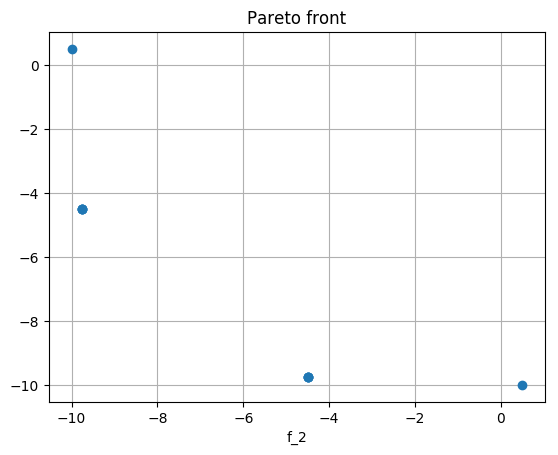

In [12]:
import PyPlot

const f1_values = [v[1] for v in multim.paretofront] 
const f2_values = [v[2] for v in multim.paretofront] 

PyPlot.plot(f1_values, f2_values, "o")
PyPlot.xlabel("f_1")
PyPlot.xlabel("f_2")
PyPlot.title("Pareto front")
PyPlot.grid()

## Quadratic optimization

- JuMP: mostly constrained, structured optimization
- Supports some forms of non-linear optimization  

Example: solving a regularized linear regression

In [13]:
Random.seed!(42)
const reg_xs = 100. .* rand(200);
const reg_ys = 5. .* rand(200) .+ reg_xs;

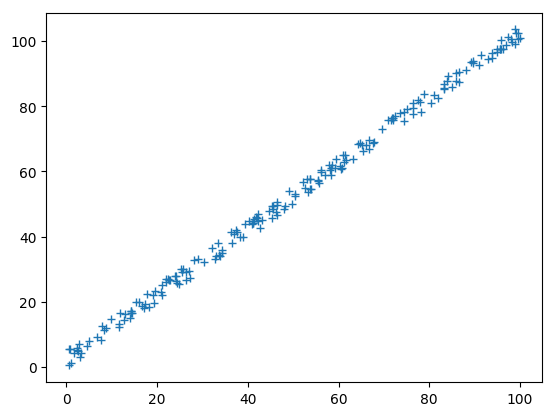

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7fdd8524dba8>

In [14]:
PyPlot.plot(reg_xs, reg_ys, "+")

In [15]:
using Ipopt: IpoptSolver

"""
Regularized linear regression of ys vs xs
"""
function constrained_opt(xs, ys, λ = 0.1)
    n = length(xs)
    nlp_model = Model(solver = IpoptSolver())
    @variable(nlp_model, -λ <= a <= λ)
    @objective(nlp_model, Min, sum((a * xs[i] - ys[i])^2 for i in 1:n))
    solve(nlp_model)
    return getvalue(a)
end

constrained_opt

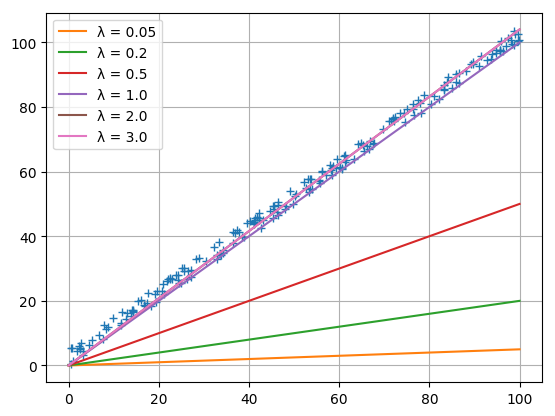


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

This is Ipopt version 3.12.8, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      200

Total number of variables............................:        1
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        1
                     variables with only upper bounds:        0
Total number of equa

PyObject <matplotlib.legend.Legend object at 0x7fdd85385c50>

In [16]:
const reg_coeff = [0.05, 0.2, 0.5, 1.0, 2.0, 3.0]
const slopes = [constrained_opt(reg_xs, reg_ys, λ) for λ in reg_coeff]

PyPlot.figure()
PyPlot.plot(reg_xs, reg_ys, "+")
PyPlot.grid()

for (a, λ) in zip(slopes, reg_coeff)
    PyPlot.plot([0.0, 100.0], [0.0, 100.0 * a], label = "λ = $λ")
end
PyPlot.legend()

## Other forms

Support for:
- Second-order conic constrains: `@SOCConstraint`
- Semi-definite constraints: `@SDconstraint`
- General non-linear optimization: `@NLconstraint` - `@NLobjective`

More coming with the MathOptInterface interface

## Q&A

```
mathieu.besancon@polymtl.ca
```
